In [1]:
import tensorflow as tf
import importlib
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import utils_triplet1
import model1
importlib.reload(utils_triplet1)
importlib.reload(model1)
from utils_triplet1 import *
from model1 import *

In [2]:
from google.colab import drive
drive.mount('/content/gdrive')

Mounted at /content/gdrive


In [3]:
!p7zip -d /content/gdrive/MyDrive/Thesis/Sketch-Icon-Dataset.7z


7-Zip (a) [64] 16.02 : Copyright (c) 1999-2016 Igor Pavlov : 2016-05-21
p7zip Version 16.02 (locale=en_US.UTF-8,Utf16=on,HugeFiles=on,64 bits,2 CPUs Intel(R) Xeon(R) CPU @ 2.20GHz (406F0),ASM,AES-NI)

Scanning the drive for archives:
  0M Scan /content/gdrive/MyDrive/Thesis/                                         1 file, 263791308 bytes (252 MiB)

Extracting archive: /content/gdrive/MyDrive/Thesis/Sketch-Icon-Dataset.7z
--
Path = /content/gdrive/MyDrive/Thesis/Sketch-Icon-Dataset.7z
Type = 7z
Physical Size = 263791308
Headers Size = 344305
Method = LZMA2:24
Solid = +
Blocks = 1

  0%      1% 649 - Sketch-Icon-Dataset/icon/emoji/grin-tears1.jpg                                                           2% 1352 - Sketch-Icon-Dataset/sketch/accessibility/braille_2.png

In [4]:
icons_test, sketches_test = get_icons_and_sketches()
sketches_test = load_test_set()
icon_dictionary, sketch_dictionary = load_icons_sketches_dic(icons_test, sketches_test)

Accuracy of top 1: 0.057547169811320756
Accuracy of top 10: 0.23679245283018868


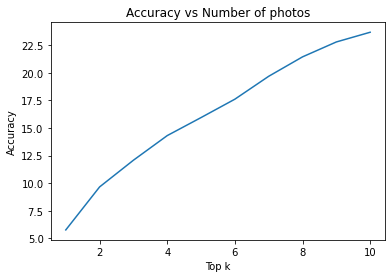

In [16]:
folder_path = "/content/gdrive/MyDrive/Results-Cluster/MyNet/Siamese Loss-CWI/05-04-2021 17-27-45/"
weights_path = folder_path + "Train Weights/"
iconClassificationModel = mynet(66)
iconClassificationModel.load_weights(weights_path + 'iconSiameseWithCWI')
sketchClassificationModel = mynet(66)
sketchClassificationModel.load_weights(weights_path + 'sketchSiameseWithCWI')
BATCH_SIZE = 128
acc_1 = 0
acc_10 = 0
sketch_representations = []
for j in range(0, len(sketches_test), BATCH_SIZE):
  batch_sketches = sketches_test[j:j+BATCH_SIZE]
  sketches_array = get_batch_sketches(batch_sketches)
  sketch_repr,_ =  sketchClassificationModel(sketches_array, training = False)
  sketch_representations.append(sketch_repr)
sketch_representations = np.vstack(sketch_representations)

icon_representations = []
for j in range(0, len(icons_test), BATCH_SIZE):
  batch_icons = icons_test[j:j+BATCH_SIZE]
  icons_array = get_batch_icons(batch_icons)
  icons_repr,_ =  iconClassificationModel(icons_array, training = False)
  icon_representations.append(icons_repr)

icon_representations = np.vstack(icon_representations)
top_k_list = [0] * 10
for k in range(len(sketch_representations)):
  sketch_repr = sketch_representations[k]
  sketch_representations_tile = np.tile(sketch_repr, len(icons_test)).reshape(len(icons_test), 64)
  diff = np.sqrt(np.mean((sketch_representations_tile - icon_representations)**2, -1))
  top_k = np.argsort(diff)[:10]
  
  for j in range(len(top_k)):
    index = top_k[j]
    if j == 0 and sketches_test[k][0].split("_")[0] == icons_test[index][0].replace(".jpg",""):
      acc_1 = acc_1 + 1
      acc_10 = acc_10 + 1
      top_k_list[j] = top_k_list[j] + 1
    elif sketches_test[k][0].split("_")[0] == icons_test[index][0].replace(".jpg",""):
      acc_10 = acc_10 + 1
      top_k_list[j] = top_k_list[j] + 1

print("Accuracy of top 1: " + str(acc_1/len(sketches_test)))
print("Accuracy of top 10: " + str(acc_10/len(sketches_test)))

axisX = [0] * 10
for i in range(0 , len(axisX)):
  axisX[i] = i + 1

for i in range(1, len(top_k_list)):
  top_k_list[i] = top_k_list[i] + top_k_list[i-1]
  top_k_list[i-1] = top_k_list[i-1] / len(sketches_test) * 100
top_k_list[9] = top_k_list[9] / len(sketches_test) * 100

plt.plot(axisX,top_k_list)
plt.title('Accuracy vs Number of photos')
plt.xlabel('Top k')
plt.ylabel('Accuracy')
plt.show()

In [17]:
rank_file = open(folder_path + "top_10.txt","w+")
top_10_list_string = ['{:.2f}'.format(x) for x in top_k_list]
for value in top_10_list_string:
  rank_file.write(value + "\n")
rank_file.close()

In [ ]:
weights_path_sketch = "/content/gdrive/MyDrive/Thesis/MyNet/Triplet Loss-CWI/28-03-2021 17-11-12/Train Weights/"
weights_path_icon = "/content/gdrive/MyDrive/Thesis/MyNet/Triplet Loss-CWI/28-03-2021 17-11-12/Train Weights/"
iconClassificationModel = mynet(66)
iconClassificationModel.load_weights(weights_path_icon + 'iconTripletWithCWI')
sketchClassificationModel = mynet(66)
sketchClassificationModel.load_weights(weights_path_sketch + 'sketchTripletWithCWI')
BATCH_SIZE = 128
acc_1 = 0
acc_10 = 0
sketch_representations = []
for j in range(0, len(sketches_test), BATCH_SIZE):
  batch_sketches = sketches_test[j:j+BATCH_SIZE]
  sketches_array = get_batch_sketches(batch_sketches)
  sketch_repr,_ =  sketchClassificationModel(sketches_array, training = False)
  sketch_representations.append(sketch_repr)
sketch_representations = np.vstack(sketch_representations)

icon_representations = []
for j in range(0, len(icons_test), BATCH_SIZE):
  batch_icons = icons_test[j:j+BATCH_SIZE]
  icons_array = get_batch_icons(batch_icons)
  icons_repr,_ =  iconClassificationModel(icons_array, training = False)
  icon_representations.append(icons_repr)

icon_representations = np.vstack(icon_representations)

for k in range(len(sketch_representations)):
  sketch_repr = sketch_representations[k]
  sketch_representations_tile = np.tile(sketch_repr, len(icons_test)).reshape(len(icons_test), 64)
  diff = np.sqrt(np.mean((sketch_representations_tile - icon_representations)**2, -1))
  top_k = np.argsort(diff)[:10]
  img = sketch_dictionary[sketches_test[k][0]]
  plt.imshow(img)
  plt.xticks([])
  plt.yticks([])
  plt.show()
  
  for j in range(len(top_k)):
    index = top_k[j]
    if j == 0 and sketches_test[k][0].split("_")[0] == icons_test[index][0].replace(".jpg",""):
      acc_1 = acc_1 + 1
      acc_10 = acc_10 + 1
    elif sketches_test[k][0].split("_")[0] == icons_test[index][0].replace(".jpg",""):
      acc_10 = acc_10 + 1

    img = icon_dictionary[icons_test[index][0]]
    plt.subplot(1, 10, j+1)
    plt.imshow(img)
    plt.xticks([])
    plt.yticks([])
  plt.show()     
print("Accuracy of top 1: " + str(acc_1/len(sketches_test)))
print("Accuracy of top 10: " + str(acc_10/len(sketches_test)))

Output hidden; open in https://colab.research.google.com to view.